In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
np.random.seed(42)

In [4]:
project_dir = 'D:\\Heart_Disease_Project'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(os.path.join(project_dir, 'notebooks'), exist_ok=True)
os.makedirs(os.path.join(project_dir, 'results'), exist_ok=True)

In [5]:
reduced_data_path = os.path.join(project_dir, 'data', 'heart_disease_reduced.csv')
df = pd.read_csv(reduced_data_path)
X = df.drop('target',axis=1)
y = df['target']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv(os.path.join(project_dir, 'data', 'heart_disease_train.csv'), index=False)
test_df.to_csv(os.path.join(project_dir, 'data', 'heart_disease_test.csv'), index=False)
print("Training and test data saved to data/ directory.")

Training set size: 242 samples
Testing set size: 61 samples
Training and test data saved to data/ directory.


In [7]:
models = {
   'Logistic Regression': LogisticRegression(random_state=42),
   'Decision Tree': DecisionTreeClassifier(random_state=42),
   'Random Forest': RandomForestClassifier(random_state=42),
   'Support Vector Machine': SVC(probability=True, random_state=42) 
}
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f'{name} trained.')

Logistic Regression trained.
Decision Tree trained.
Random Forest trained.
Support Vector Machine trained.


In [8]:
metrics = {}
roc_plots = {}
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    print(f"\n{name} Evaluation:")
    print("y_test unique values:", np.unique(y_test))
    print("y_pred unique values:", np.unique(y_pred))
    print("y_test shape:", y_test.shape, "y_pred shape:", y_pred.shape)
    print("NaN in y_test:", np.isnan(y_test).any(), "NaN in y_pred:", np.isnan(y_pred).any())
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred,average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(5):  # 5 classes
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Macro-average ROC AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(5):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 5
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    metrics[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc['macro']
    } 
    roc_plots[name] = (fpr['macro'], tpr['macro'], roc_auc['macro'])

for name, m in metrics.items():
    print(f'\n{name} Metrics:')
    for k, l in m.items():
        print(f'{k}: {l:.4f}')


Logistic Regression Evaluation:
y_test unique values: [0 1 2 3 4]
y_pred unique values: [0 1 2 3]
y_test shape: (61,) y_pred shape: (61,)
NaN in y_test: False NaN in y_pred: False

Decision Tree Evaluation:
y_test unique values: [0 1 2 3 4]
y_pred unique values: [0 1 2 3]
y_test shape: (61,) y_pred shape: (61,)
NaN in y_test: False NaN in y_pred: False

Random Forest Evaluation:
y_test unique values: [0 1 2 3 4]
y_pred unique values: [0 1 2 3]
y_test shape: (61,) y_pred shape: (61,)
NaN in y_test: False NaN in y_pred: False

Support Vector Machine Evaluation:
y_test unique values: [0 1 2 3 4]
y_pred unique values: [0 1 2 3]
y_test shape: (61,) y_pred shape: (61,)
NaN in y_test: False NaN in y_pred: False

Logistic Regression Metrics:
Accuracy: 0.6066
Precision: 0.5060
Recall: 0.6066
F1-score: 0.5428
AUC: 0.8383

Decision Tree Metrics:
Accuracy: 0.4590
Precision: 0.4561
Recall: 0.4590
F1-score: 0.4564
AUC: 0.5363

Random Forest Metrics:
Accuracy: 0.5082
Precision: 0.4549
Recall: 0.5082

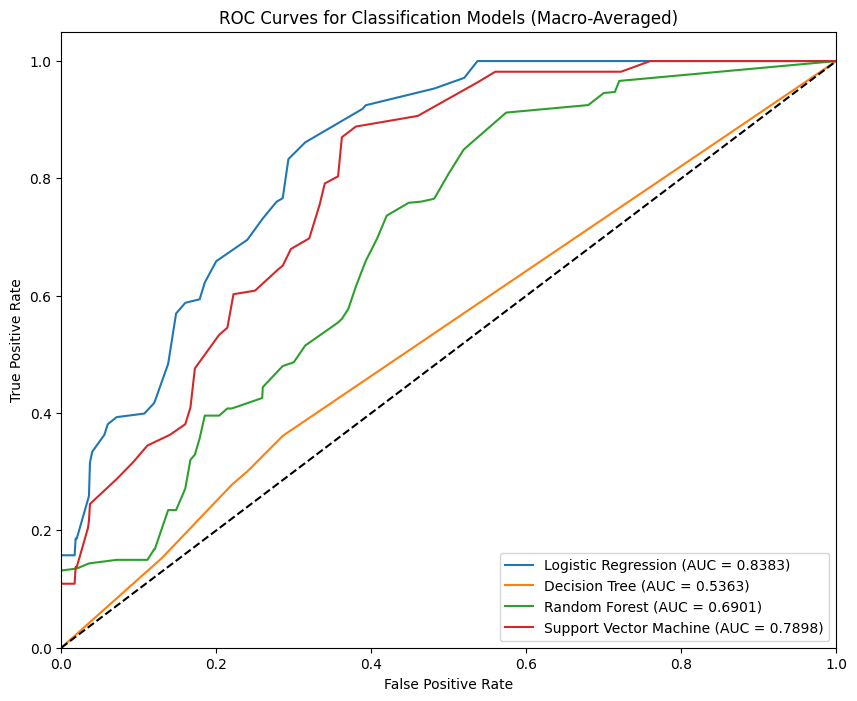

ROC curves saved to D:\Heart_Disease_Project\results\roc_curves.png


In [9]:
plt.figure(figsize=(10,8))
for name, (fpr, tpr, roc_auc) in roc_plots.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.title('ROC Curves for Classification Models (Macro-Averaged)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
roc_plot_path = os.path.join(project_dir, 'results', 'roc_curves.png')
plt.savefig(roc_plot_path)
plt.show()
print(f"ROC curves saved to {roc_plot_path}")

In [10]:
metrics_path = os.path.join(project_dir, 'results', 'evaluation_metrics.txt')
with open(metrics_path, 'w') as f:
    for name, m in metrics.items():
        f.write(f"{name} Metrics:\n")
        for k, v in m.items():
            f.write(f"{k}: {v:.4f}\n")
        f.write("\n")
print(f"Performance metrics saved to {metrics_path}")

Performance metrics saved to D:\Heart_Disease_Project\results\evaluation_metrics.txt
